<a href="https://colab.research.google.com/github/valentinaslisser/valentina_slisser/blob/main/ExactInference_student(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Start with your name(s) and student number(s)**

Team:

*Valentina Slisser (14955792)

# Outline

In this notebook we will develop algorithms for **exact sum-product inference** in PGMs, specifically via  the _Variable Elimination_ (VE) algorithm.

VE uses the structure of the graph to (more) efficiently answer probability queries such as marginals and conditionals. There is a variant of VE that can be used for a related (but different) type of inference, the so-called max-product inference, but we will not be demonstrating max-product inference in this notebook.

We will use an example of reasoning w.r.t. a medical diagnosis to build up the intuition and the methods.

This is a high-level outline of the notebook, you will find exercises in most sections.

1. We start with constructing the BN (DAG + CPD)
2. We will implement and reason about naive sum-product inference for probability queries
3. Next, we will implement and reason about the VE algorithm
4. We will optimize VE, using graphical separation
5. Then, we will look at different orders of eliminating variables and how this affects VE's efficiency
6. Finally, there is a bonus exercise on ordering.

**Table of Exercises**

The exercises and the points they are worth are shown below:


1. Exercise - Naive Marginalization [2]
2. Exercise - Basic VE [2]
3. Exercise - VE and Graphical Separation - Part I [1]
4. Exercise - VE and Graphical Separation - Part II [2]
5. Exercise - Order heuristics - Part I [2]
6. Exercise - Order Heuristics - Part II [1]
7. Exercise - Bonus [1]

There are 11 points above, but the assignment grade is capped at 10. That is, `grade = min(10, "total points acquired")`.

**Use of AI tools**

In this course we expect _you_ and your team members to author your work.
AI tools are not to be used for drafts, nor code completion, nor revisions, nor as a 'study tool', nor as a source of feedback. If you do use AI, it should not contribute to the substance of what you present as your work.  

At the end of this notebook you will find a section on _Use of AI tools_. **Make sure to read and complete it**.
By submitting a version of this notebook for assessment, you agree with our terms.

# Setting Up

Take care of dependencies:

In [ ]:
!pip install tabulate
!pip install --upgrade --force-reinstall  git+https://github.com/probabll/pgmini.git

  Cloning https://github.com/probabll/pgmini.git to /tmp/pip-req-build-3f6ior5x
  Running command git clone --filter=blob:none --quiet https://github.com/probabll/pgmini.git /tmp/pip-req-build-3f6ior5x
  Resolved https://github.com/probabll/pgmini.git to commit 3749b64cf8730163fe3045ca20a8b0ac98cfae06


In [ ]:
import pgmini
assert pgmini.__version__ == '0.3.0', "Don't forget to update pgmini and restart your kernel\n!pip install --upgrade --force-reinstall  git+https://github.com/probabll/pgmini.git"

In [ ]:
from pgmini.m1 import OutcomeSpace, DAG
from pgmini.m2 import TabularFactor, UGraph
from pgmini.m3 import TabularCPDFactor, PGM, BayesianNetwork, MarkovNetwork
import functools
import itertools
from collections import defaultdict
import numpy as np
from tabulate import tabulate
import random
import matplotlib.pyplot as plt

# Introduction: Medical Diagnosis

The example that we will reason about is one where we want can predict probability of bronchitis, based on other variables (smoking, influenza, couching, etc.).
Note: The probabilities in this example do not necessarily reflect true probabilities in the real world.

The BN is defined by the following conditional probabilities:

* $P(\verb+Influenza+ = 1) = 0.1$
* $P(\verb+Smokes+ = 1) = 0.3$
* $P(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.2$
* $P(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.01$
* $P(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.95$
* $P(\verb+Fever+ = 1| \verb+Influenza+ = 0) = 0.1$
* $P(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99$
* $P(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.95$
* $P(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.75$
* $P(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001$
* $P(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.75$
* $P(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.05$
* $P(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.5$
* $P(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001$


We can generate the factors similar to last weeks, but this time we are using a new type of object: TabularCPDFactor. This is essentially a TabularFactor, but its scope is made of `parents` and a `child`, and the table must form a valid CPD. This kind of object is convenient in the context of VE because VE builds largely on _factor operations_, which TabularFactor from the previous module supports.

In [ ]:
medical_outcome_spaces = {
    'I': OutcomeSpace(['i0', 'i1']),
    'S': OutcomeSpace(['s0', 's1']),
    'ST': OutcomeSpace(['st0', 'st1']),
    'F': OutcomeSpace(['f0', 'f1']),
    'B': OutcomeSpace(['b0', 'b1']),
    'C': OutcomeSpace(['c0', 'c1']),
    'W': OutcomeSpace(['w0', 'w1'])
}

# Factors
phi_I = TabularCPDFactor([], 'I', medical_outcome_spaces, [0.9, 0.1])
phi_S = TabularCPDFactor([], 'S', medical_outcome_spaces, [0.7, 0.3])
phi_ST = TabularCPDFactor(['I'], 'ST', medical_outcome_spaces, [[0.99, 0.01], [0.8, 0.2]])
phi_F = TabularCPDFactor(['I'], 'F', medical_outcome_spaces, [[0.9, 0.1], [0.05, 0.95]])
phi_B = TabularCPDFactor(['I', 'S'], 'B', medical_outcome_spaces,
[[[0.999, 0.001], [0.25, 0.75]], [[0.05, 0.95], [0.1, 0.9]]])
phi_C = TabularCPDFactor(['B'], 'C', medical_outcome_spaces, [[0.95, 0.05], [0.25, 0.75]])
phi_W = TabularCPDFactor(['B'], 'W', medical_outcome_spaces, [[0.999, 0.001], [0.5, 0.5]])
###

# Display factors as tables
for i, phi in enumerate([phi_I, phi_S, phi_ST, phi_F, phi_B, phi_C, phi_W], 1):
    print(phi.display(factor_name=f"phi{i}"))
    print()



I      phi1
---  ------
i0      0.9
i1      0.1

S      phi2
---  ------
s0      0.7
s1      0.3

I    ST      phi3
---  ----  ------
i0   st0     0.99
i0   st1     0.01
i1   st0     0.8
i1   st1     0.2

I    F      phi4
---  ---  ------
i0   f0     0.9
i0   f1     0.1
i1   f0     0.05
i1   f1     0.95

I    S    B      phi5
---  ---  ---  ------
i0   s0   b0    0.999
i0   s0   b1    0.001
i0   s1   b0    0.25
i0   s1   b1    0.75
i1   s0   b0    0.05
i1   s0   b1    0.95
i1   s1   b0    0.1
i1   s1   b1    0.9

B    C      phi6
---  ---  ------
b0   c0     0.95
b0   c1     0.05
b1   c0     0.25
b1   c1     0.75

B    W      phi7
---  ---  ------
b0   w0    0.999
b0   w1    0.001
b1   w0    0.5
b1   w1    0.5



In `pgmini.m3` we provide you with two types of PGMs, namely BNs and MNs. You can construct one such PGM from the factors directly:

In [ ]:
medical_bn = BayesianNetwork([phi_I, phi_S, phi_ST, phi_F, phi_B, phi_C, phi_W])
print(medical_bn.dag)

+-----------+---------+
| parents   | child   |
+===========+=========+
|           | I       |
+-----------+---------+
|           | S       |
+-----------+---------+
| I         | F       |
+-----------+---------+
| I         | ST      |
+-----------+---------+
| I, S      | B       |
+-----------+---------+
| B         | C       |
+-----------+---------+
| B         | W       |
+-----------+---------+


Lets loop through the joint assignments and plot them in a table:

In [ ]:
def display_full_table(pgm, rvs=None):
    """
    pgm: an instance of PGM
    rvs: optionally specify the order in which to list rvs in the table
    """
    table = []
    # rvs = ['I', 'S', 'ST', 'F', 'B', 'C', 'W']
    if rvs is None:
        rvs = list(pgm.iternodes())
    for assignment in pgm.enumerate_joint_assignments(rvs):
        table.append([assignment[rv] for rv in rvs] + [pgm.evaluate(assignment)])
    print(tabulate(table, headers=rvs + ['~P']))
    print("Sum", sum(row[-1] for row in table))

In [ ]:
display_full_table(medical_bn)

I    S    ST    F    B    C    W             ~P
---  ---  ----  ---  ---  ---  ---  -----------
i0   s0   st0   f0   b0   c0   w0   0.532198
i0   s0   st0   f0   b0   c0   w1   0.00053273
i0   s0   st0   f0   b0   c1   w0   0.0280104
i0   s0   st0   f0   b0   c1   w1   2.80384e-05
i0   s0   st0   f0   b1   c0   w0   7.01662e-05
i0   s0   st0   f0   b1   c0   w1   7.01662e-05
i0   s0   st0   f0   b1   c1   w0   0.000210499
i0   s0   st0   f0   b1   c1   w1   0.000210499
i0   s0   st0   f1   b0   c0   w0   0.0591331
i0   s0   st0   f1   b0   c0   w1   5.91922e-05
i0   s0   st0   f1   b0   c1   w0   0.00311227
i0   s0   st0   f1   b0   c1   w1   3.11538e-06
i0   s0   st0   f1   b1   c0   w0   7.79625e-06
i0   s0   st0   f1   b1   c0   w1   7.79625e-06
i0   s0   st0   f1   b1   c1   w0   2.33888e-05
i0   s0   st0   f1   b1   c1   w1   2.33888e-05
i0   s0   st1   f0   b0   c0   w0   0.00537573
i0   s0   st1   f0   b0   c0   w1   5.38111e-06
i0   s0   st1   f0   b0   c1   w0   0.000282933
i0

## Naive Marginalization

Now that we have the graph, we can compute marginal probabilities. The sum and product rules tell us that we need to sum over all possible values of all other variables:

$$
P(B) = \sum_{I, S, ST, F, C, W} P(I, S, ST, F, B, C, W)
$$

Expanding the joint distribution using the BN factorization, we get:

$$
P(B) = \sum_{I, S, ST, F, C, W} \prod_{X} P(X \mid \text{pa}(X))
$$

where $X$ ranges over all variables in the network ($I, S, ST, F, B, C, W$) and $\text{pa}(X)$ denotes the parents of $X$ in the graph.

Note that each P() can be considered a factor with scope {X, Pa(X)}


We implemented the naive approach below, make sure to understand the code s.t. you can answer questions about it later. Feel free to play with the code itself.

In [ ]:
def naive_exact_inference(query_rvs: set, evidence: dict, pgm: PGM, reduce_first=False, normalize=False, trace=None):
    """
    Return the (unnormalized) distribution over Q given E=e.

    In naive exact inference we build the complete joint factor before conditioning
    on evidence, then marginalise the necessary variables.

    A first optimisation we can consider is to reduce to evidence first, and only then
    multiply all factors together.

    query_rvs: the set Q
    evidence: a dict representing the evidence assignment E=e
        Q and E are disjoint
    pgm: a PGM (a BN or an MN)
    reduce_first: an optimisation whereby we reduce the factors to evidence
        before taking their product
    normalize: whether or not we normalize the result.
    trace: used to log some information about complexity
    """
    assert len(set(query_rvs) & evidence.keys()) == 0, "Q and E should be disjoint"

    # Log scope of factors we start with
    if trace is not None:
        trace.extend([(None, factor.scope) for factor in pgm.iterfactors()])

    if reduce_first:
        # reduce all factors to evidence
        factors = [factor.reduce(evidence) for factor in pgm.iterfactors()]
        out = functools.reduce(lambda a, b: a.product(b), factors)
        if trace is not None: # Log what we did
            trace.append((out.scope))
    else:
        out = functools.reduce(lambda a, b: a.product(b), pgm.iterfactors())
        if trace is not None: # Log what we did
            trace.append((out.scope))
        out = out.reduce(evidence)


    all_rvs = set(pgm.iternodes())
    rvs_to_marginalize = all_rvs - set(query_rvs) - evidence.keys()

    for rv in rvs_to_marginalize:
        out = out.marginalize(rv)

    return out.normalize() if normalize else out

In [ ]:
# Example query

trace = []
print(f"Reduce later: \n{naive_exact_inference({'B'}, {'W': 'w0', 'C': 'c0'}, medical_bn, trace=trace, reduce_first=False, normalize=True)}")
print(f"\nScope of factor product: {trace[-1]}\n")

Reduce later: 
B        Value
---  ---------
b0   0.947377
b1   0.0526229

Scope of factor product: ('I', 'S', 'ST', 'F', 'B', 'C', 'W')



**EXERCISE - Naive marginalization**

Make sure to run example queries for your answers. For each of the questions show how this can be seen from running the example queries (if applicable).


**Question 1:** You have a friend that coughs and does not smoke, what is the chance of them having a fever? Report how you used the code

ANSWER: i use the pgm=medical_bn bayesian network, and query it about fever F. the chance of haveing a fever is 0.618868. i used normalize to ensure it is a proper prohabilbility distribution.


The following questions concern memory requirement for computing $P(F|C=c1, S=s0)$ using this naive approach:

**Question 2:** Given reduction-later version, what is the scope and scope size of the factor product?

ANSWER: all of the variables of the bayesian network, so 7 variables.



**Question 3** Given the reduction-first version, what is the scope and scope size of the factor product?

ANSWER: all of the variables that are not in the evidence.



**Question 4** For each method, what is the size of its biggest factor table (variables are binary)?

ANSWER: 2^7



**Question 5** As we add more (binary) variables what happens to the memory requirement (max table size)? Discuss the big-O complexity in your answer for each of the methods. You can refer to the size of query rvs as n and the size of the evidence set as e.

ANSWER: for the naive method: O= 2^n, it has exponential growth. n is the number of variables and the max table size is 2^n-e.




In [ ]:
trace = []
fever_prob = naive_exact_inference(
    query_rvs={'F'},
    pgm=medical_bn,
    trace=trace,
    normalize=True
)
print("Probability of Fever given Coughing and Not Smoking:", fever_prob)

# coughing is c1, not smoking is s0.

Probability of Fever given Coughing and Not Smoking: F       Value
---  --------
f0   0.381132
f1   0.618868


# Basic Variable Elimination (VE) for Sum-Product Inference

VE attempts to tackle the exponential increase of the tabular view of the entire joint distribution.

The core of the algorithm is noticing that we can move the products and sums around to reduce the sizes of intermediate tables (hence: variable-elimination). Based on a given order of variables, we combine the factors for which that variable is in the scope (using factor product), and then marginalize out that variable.

Below we provide you with the code. Make sure to read the code so that you can understand and reason about it later.



In [ ]:
def split_factors(rv, all_factors):
    """
    Splits all_factors into a list that's relevant to the rv and another that's irrelevant.
    A factor is "relevant" to an rv if that rv is in the factor's scope.
    """
    relevant, irrelevant = [], []
    for factor in all_factors:
        if rv in factor:
            relevant.append(factor)
        else:
            irrelevant.append(factor)
    return relevant, irrelevant

def random_order(node):
    """
    Assign a random number to the node.
    This will lead to a random order of elimination
    """
    return random.random()


def variable_elimination(query_rvs: set, evidence: dict, pgm: PGM, key=None, normalize=False, trace=None):
    """
    Return a factor representation of the (unnormalised) distribution over Q given E=e.

    query_rvs: the set Q
    evidence: a dict representing the evidence assignment E=e
        Q and E are disjoint
    factors: a PGM (a BN or an MN)
    key: use to specify the order of elimination
        (this is passed to python's sorted function)
    trace: if provided, we log here each variable that was eliminated, in order, and the scope
        of the factor from which we eliminated it
    """
    assert len(set(query_rvs) & evidence.keys()) == 0, "Q and E should be disjoint"

    if isinstance(pgm, BayesianNetwork):  # we need to moralise BNs
        pgm = MarkovNetwork(pgm.iterfactors())

    # Log scope of factors we start with
    if trace is not None:
        trace.extend([(None, factor.scope) for factor in pgm.iterfactors()])

    # reduce all factors using the available evidence
    factors = [factor.reduce(evidence) for factor in pgm.iterfactors()]
    # rvs that need to be eliminated/marginalised
    all_rvs = set(pgm.iternodes())
    rvs_to_marginalize = all_rvs - set(query_rvs) - evidence.keys()

    # eliminate each rv in order
    for rv in sorted(rvs_to_marginalize, key=key):
        # separate factors containing this rv in their scope
        involved, factors = split_factors(rv, factors)
        if not involved:  # nothing to do here
            continue
        # take the product of the factors involved in this elimination step
        new_factor = functools.reduce(lambda a, b: a.product(b), involved)

        # Log intermediate factor products
        if trace is not None:
            trace.append((rv, new_factor.scope))

        # marginalise / eliminate the rv from the factor product
        new_factor = new_factor.marginalize({rv})
        # keep the factor for future use
        factors.append(new_factor)

    # multiply whatever factors remain
    out = functools.reduce(lambda a, b: a.product(b), factors)
    return out.normalize() if normalize else out

This is an example order of elimiantion:

In [ ]:
for node in sorted(medical_bn.iternodes(), key=random_order):
    print(node)

I
ST
B
F
W
S
C


We provide some example runs of VE:

In [ ]:
print(variable_elimination({'F'}, dict(), medical_bn).normalize())

trace = []
print(variable_elimination({'B'}, {'W': 'w0', 'C': 'c0'}, medical_bn, trace=trace).normalize())
print(tabulate(trace, headers=['sum', 'scope']))

F      Value
---  -------
f0     0.815
f1     0.185
B        Value
---  ---------
b0   0.947377
b1   0.0526229
sum    scope
-----  ---------------------
       ('I',)
       ('S',)
       ('I', 'ST')
       ('I', 'F')
       ('I', 'S', 'B')
       ('B', 'C')
       ('B', 'W')
F      ('I', 'F')
I      ('I', 'ST', 'S', 'B')
S      ('S', 'ST', 'B')
ST     ('ST', 'B')


Below, we provide two helpers for the kind of information you will need in the following exercise. Read the exercise first, then complete the helpers. _Remark:_ if you find it difficult to work with our helpers, it is okay to create your own plotting code, but then we expect the plot to be as clear and as informative as ours.

In [ ]:
def get_max_factor_scope_size(pgm, rv, evidence = dict(), elimination_algorithm=variable_elimination, key=None):
    """
    Get the maximal factor scope size for a given PGM, rv, evidence, elimination algorithm and key.
    """

    trace = []
    # Run variable elimination with tracing
    elimination_algorithm(
        query_rvs={rv},
        evidence=evidence,
        pgm=pgm,
        trace=trace,
        key=key
    )

    # Find the maximum scope size from the trace
    max_scope_size = max(
        (len(scope) for _, scope in trace if scope),
        default=0
    )

    return max_scope_size




def plot_max_factor_scope_sizes(pgm, num_runs=1, evidence = dict(), elimination_algorithm=variable_elimination, key=random_order):
    """
    Plot the histogram of the maximal factor scope sizes for many random orders.
    """

    max_scopes = []

    for rv in pgm.iternodes():
        for _ in range(num_runs):
            # Check if the rv is in the evidence
            if rv in evidence:
                continue
            max_scope = get_max_factor_scope_size(pgm, rv, evidence, elimination_algorithm, key)
            max_scopes.append(max_scope)

    # plot the histogram with number in middle of bin
    plt.hist(max_scopes, bins=range(1, max(max_scopes) + 2), align='left', edgecolor='black')
    # Add a vertical line at the scope size of the naive approach
    plt.axvline(x=len(pgm.dag.nodes), color='red', linestyle='--', label='Naive Approach')
    plt.title('Histogram of Maximal Factor Scope Sizes ')
    plt.xlabel('Maximal Factor Scope Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()



In [ ]:
assert get_max_factor_scope_size(medical_bn, 'I', dict(), variable_elimination) == 5
assert get_max_factor_scope_size(medical_bn, 'B', dict(), variable_elimination) == 4
assert get_max_factor_scope_size(medical_bn, 'F', dict(), variable_elimination) == 5
assert get_max_factor_scope_size(medical_bn, 'C', dict(), variable_elimination) == 5
assert get_max_factor_scope_size(medical_bn, 'W', dict(), variable_elimination) == 5

NameError: name 'min_lexicographic' is not defined

<Figure size 1200x600 with 0 Axes>

### EXERCISE - Basic VE ###
In the above examples we computed probabilties in a way that is more efficient than the naive implementation that we started with. But how much more efficient? Run the algorithm multiple times, using random elimination orderings, in order to compute all _single-variable marginal probability queries_ (P(I), P(S), P(ST), etc.). Find the size of the scope of the biggest factor product for each run and plot them in a histogram. Make sure to use random orderings when running the algorithm multiple times. To plot the histogram you must first implement the helper function.

Specifically answer the following question:

**Question 1**: What are the sizes of the biggest (intermediate) factor(product)s? Report what you see in the plots

ANSWER: ...


**Question 2**: How does this compare to the size of the biggest (intermediate) factor(product) in the naive case?

ANSWER: ...

**Question 3**: How come VE never produces as big factor products as the naive case, regardless of which ordering we choose? Refer to the operations in the code in your answer.

ANSWER: ...




# Graphical Seperation #


In the lectures we have seen that we can further optimize the VE algorithm by using seperation structure in the graph.

If an rv Y to be eliminated is separate from Q given E, then we can eliminate Y without actually manipulating the factors relevant to it.

### EXERCISE - Graphical Seperation - Part I ###

In this exercise you have to implement `variable_elimination_with_separation`, which modifies `variable_elimination` to make use of graphical separation in an attempt to spare unnecessary computation.

Note that PGM has a method `separate(X, Y, Z)`.

In [ ]:
def variable_elimination_with_separation(query_rvs: set, evidence: dict, pgm: PGM, key=None, normalize=False, trace=None):
    """
    Return a factor representation of the (unnormalised) distribution over Q given E=e.

    query_rvs: the set Q
    evidence: a dict representing the evidence assignment E=e
        Q and E are disjoint
    factors: a PGM (a BN or an MN)
    key: use to specify the order of elimination
        (this is passed to python's sorted function)
    normalize: whether or not we normalize the result.
    trace: if provided, we log here each variable that was eliminated, in order, and the scope
        of the factor from which we eliminated it
    """
    assert len(set(query_rvs) & evidence.keys()) == 0, "Q and E should be disjoint"


    if isinstance(pgm, BayesianNetwork):  # we moralise the BN
        pgm = MarkovNetwork([factor for factor in pgm.iterfactors()])
    # Log scope of factors we start with
    if trace is not None:
        trace.extend([(None, factor.scope) for factor in pgm.iterfactors()])

    # reduce all factors using the available evidence
    factors = [factor.reduce(evidence) for factor in pgm.iterfactors()]
    # rvs that need to be eliminated/marginalised
    all_rvs = set(pgm.iternodes())
    Q = set(query_rvs)
    E = set(evidence.keys())
    rvs_to_marginalize = all_rvs - Q - E


    # eliminate each rv in order
    for rv in sorted(rvs_to_marginalize, key=key):
        # separate factors containing this rv in their scope
        involved, factors = split_factors(rv, factors)
        if not involved:  # nothing to do here
            if trace is not None:  # possibly log what we did
                trace.append((rv, tuple()))
            continue

        is_separated = all(
            pgm.separate(rv, q, set(E)) for q in Q
        )

        if is_separated:
            if trace is not None:
                trace.append((rv, ()))  # Log the separation
            continue


        # take the product of the factors involved in this elimination step
        new_factor = functools.reduce(lambda a, b: a.product(b), involved)
        if trace is not None:  # possibly log what we did
            trace.append((rv, new_factor.scope))
        # marginalise / eliminate the rv from the factor product
        new_factor = new_factor.marginalize({rv})
        # keep the factor for future use
        factors.append(new_factor)

    # multiply whatever factors remain
    out = functools.reduce(lambda a, b: a.product(b), factors)
    return out.normalize() if normalize else out

Some checks the code works as it should

In [ ]:
trace = []
variable_elimination_with_separation(query_rvs = {'F'}, evidence = {'I':'i0'}, pgm = medical_bn, trace=trace).normalize()
assert trace[-1][1] == ()
variable_elimination_with_separation(query_rvs = {'B'}, evidence = {'I':'i0'}, pgm = medical_bn, trace=trace).normalize()
assert trace[-1][1] == ('B', 'W')

This new algorithm should perform better when variables are seperated from the rest of the graph, given the evidence.

In [ ]:
trace = []
# print(variable_elimination(query_rvs = {'F'}, evidence = {'I':'i0'}, pgm = medical_bn, trace=trace).normalize())
variable_elimination(query_rvs = {'F'}, evidence = {'I':'i0'}, pgm = medical_bn, trace=trace).normalize()
print(tabulate(trace, headers=['sum', 'scope']))


trace = []
# print(variable_elimination_with_separation(query_rvs = {'F'}, evidence = {'I':'i0'}, pgm = medical_bn, trace=trace).normalize())
variable_elimination_with_separation(query_rvs = {'F'}, evidence = {'I':'i0'}, pgm = medical_bn, trace=trace).normalize()
# We should see an absence of factor products as F is seperate from the rest of the graph given the evidence
print(tabulate(trace, headers=['sum', 'scope']))


sum    scope
-----  --------------------
       ('I',)
       ('S',)
       ('I', 'ST')
       ('I', 'F')
       ('I', 'S', 'B')
       ('B', 'C')
       ('B', 'W')
B      ('S', 'B', 'C', 'W')
C      ('S', 'C', 'W')
S      ('S', 'W')
ST     ('ST',)
W      ('W',)
sum    scope
-----  ---------------
       ('I',)
       ('S',)
       ('I', 'ST')
       ('I', 'F')
       ('I', 'S', 'B')
       ('B', 'C')
       ('B', 'W')
B      ()
C      ()
S      ()
ST     ()
W      ()



Evidence: {'I': 'i0'}
Standard VE Trace:
Variable: None, Scope: ('I',)
Variable: None, Scope: ('S',)
Variable: None, Scope: ('I', 'ST')
Variable: None, Scope: ('I', 'F')
Variable: None, Scope: ('I', 'S', 'B')
Variable: None, Scope: ('B', 'C')
Variable: None, Scope: ('B', 'W')
Variable: C, Scope: ('B', 'C')
Variable: F, Scope: ('F',)
Variable: S, Scope: ('S', 'B')
Variable: ST, Scope: ('ST',)
Variable: W, Scope: ('B', 'W')

Separation VE Trace:
Variable: None, Scope: ('I',)
Variable: None, Scope: ('S',)
Variable: None, Scope: ('I', 'ST')
Variable: None, Scope: ('I', 'F')
Variable: None, Scope: ('I', 'S', 'B')
Variable: None, Scope: ('B', 'C')
Variable: None, Scope: ('B', 'W')
Variable: C, Scope: ('B', 'C')
Variable: F, Scope: ()
Variable: S, Scope: ('S', 'B')
Variable: ST, Scope: ('ST',)
Variable: W, Scope: ('B', 'W')

Evidence: {'I': 'i1'}
Standard VE Trace:
Variable: None, Scope: ('I',)
Variable: None, Scope: ('S',)
Variable: None, Scope: ('I', 'ST')
Variable: None, Scope: ('I', 'F')

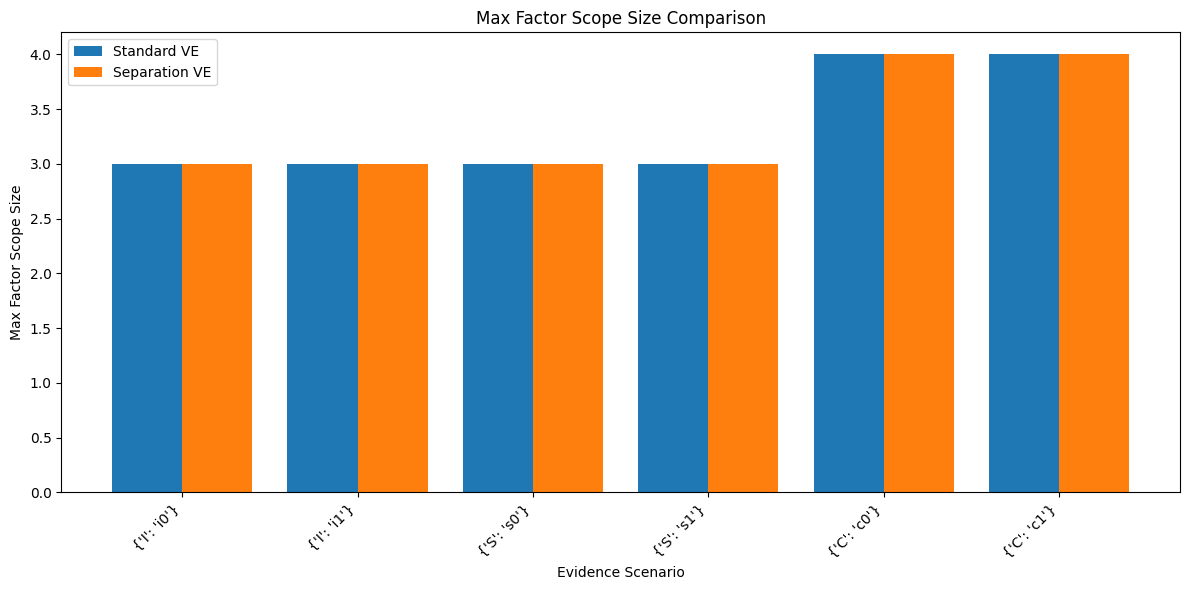

Evidence {'I': 'i0'}:
  Standard VE Max Scope: 3
  Separation VE Max Scope: 3
Evidence {'I': 'i1'}:
  Standard VE Max Scope: 3
  Separation VE Max Scope: 3
Evidence {'S': 's0'}:
  Standard VE Max Scope: 3
  Separation VE Max Scope: 3
Evidence {'S': 's1'}:
  Standard VE Max Scope: 3
  Separation VE Max Scope: 3
Evidence {'C': 'c0'}:
  Standard VE Max Scope: 4
  Separation VE Max Scope: 4
Evidence {'C': 'c1'}:
  Standard VE Max Scope: 4
  Separation VE Max Scope: 4


In [ ]:
# Before coding the following cell, make sure to read the exercise below it.

# Add plots here that show the difference in max factor scope size between the two algorithms
# You should use the plotting function from the previous exercise
# Use a high number of runs to get a good estimate

# **Solution**

def compare_ve_methods():

    evidence_scenarios = [
        {'I': 'i0'},  # No Influenza
        {'I': 'i1'},  # With Influenza
        {'S': 's0'},  # No Smoking
        {'S': 's1'},  # Smoking
        {'C': 'c0'},  # No Coughing
        {'C': 'c1'}   # Coughing
    ]

    results = {
        'standard_ve': [],
        'separation_ve': [],
        'evidence_scenario': []
    }

    def plot_max_factor_scope_comparison():
        plt.figure(figsize=(12, 6))

        standard_scopes = results['standard_ve']
        separation_scopes = results['separation_ve']
        evidence_scenarios = results['evidence_scenario']

        x = range(len(evidence_scenarios))
        plt.bar(x, standard_scopes, width=0.4, label='Standard VE', align='center')
        plt.bar([i+0.4 for i in x], separation_scopes, width=0.4, label='Separation VE', align='center')

        plt.title('Max Factor Scope Size Comparison')
        plt.xlabel('Evidence Scenario')
        plt.ylabel('Max Factor Scope Size')
        plt.xticks([i+0.2 for i in x], [str(ev) for ev in evidence_scenarios], rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

    for evidence in evidence_scenarios:
        standard_trace = []
        variable_elimination(
            query_rvs={'B'},
            evidence=evidence,
            pgm=medical_bn,
            trace=standard_trace
        )

        separation_trace = []
        variable_elimination_with_separation(
            query_rvs={'B'},
            evidence=evidence,
            pgm=medical_bn,
            trace=separation_trace
        )

        standard_max_scope = max(
            (len(scope) for _, scope in standard_trace if isinstance(scope, tuple) and scope),
            default=0
        )
        separation_max_scope = max(
            (len(scope) for _, scope in separation_trace if isinstance(scope, tuple) and scope),
            default=0
        )

        results['standard_ve'].append(standard_max_scope)
        results['separation_ve'].append(separation_max_scope)
        results['evidence_scenario'].append(evidence)

        print(f"\nEvidence: {evidence}")
        print("Standard VE Trace:")
        for step in standard_trace:
            print(f"Variable: {step[0]}, Scope: {step[1]}")

        print("\nSeparation VE Trace:")
        for step in separation_trace:
            print(f"Variable: {step[0]}, Scope: {step[1]}")

    plot_max_factor_scope_comparison()

    return results


results = compare_ve_methods()

# Print the comparison results
for scenario, standard, separation in zip(
    results['evidence_scenario'],
    results['standard_ve'],
    results['separation_ve']
):
    print(f"Evidence {scenario}:")
    print(f"  Standard VE Max Scope: {standard}")
    print(f"  Separation VE Max Scope: {separation}")
    if standard != separation:
        print("  DIFFERENT SCOPE SIZES!")
# **End of Solution**

### EXERCISE - Graphical Seperation - Part II ###


**Question 1** For which variable outcomes in the evidence do the algorithms give different max factor scope size? Run the plotting function for those variables as part of your answer.

ANSWER: in the scenarios with no influenza or no smoking the max factor scope sizes differ the most. this is because the seperation algorithm can skip conditionally independent variables. this can result in smaller factor products. so the differences occur when the evidence creates conditional independence that can be used efficiently by the separation algorithm.


**Question 2** What do you observe w.r.t. maximal factor scope size for queries using this evidence?

ANSWER: it varies depending on the evdicence because some evidence causes natural separation in the network which can ensure that the algorithm reduces the complecity by skipping vartiables. and this can simplify prohability calculations.

**Question 3** Why do these queries result in smaller max factor scope?

ANSWER: because the evidence can create conditional independence pathways in the network. because when the variables become irrelevant because of the evidence their elimination can be skipped allowing the algorithm to only work with directly relevant variables and compute the prohabilities more efficiently.


# Elimination Order Heuristics


We have seen that the VE algorithm always outperforms the naive approach, but the different orders produce different sizes of the biggest factor product. For small graphs like the one in this example that is fine, but for bigger graphs this can become problematic easily. In the following part of the notebook we will look at different deterministic orderings. A small note here is that finding the optimal ordering is NP-complete. What we can do however, is define heurstics based on graph properties.

The general idea is to code a function that could be used as `key` for python's `sorted`.

In [ ]:
def min_lexicographic(node):
    """Return the lexicographically smallest node"""
    return str(node)

for node in sorted(medical_bn.iternodes(), key=min_lexicographic):
    print(node)

B
C
F
I
S
ST
W


In [ ]:
trace = []
print(variable_elimination({'B'}, dict(), medical_bn, trace=trace, key=min_lexicographic).normalize())
print(tabulate(trace, headers=['sum', 'scope']))


B      Value
---  -------
b0   0.70337
b1   0.29663
sum    scope
-----  ---------------------
       ('I',)
       ('S',)
       ('I', 'ST')
       ('I', 'F')
       ('I', 'S', 'B')
       ('B', 'C')
       ('B', 'W')
C      ('B', 'C')
F      ('I', 'F')
I      ('I', 'ST', 'S', 'B')
S      ('S', 'ST', 'B')
ST     ('ST', 'B')
W      ('B', 'W')


In [ ]:
plot_max_factor_scope_sizes(medical_bn, key=min_lexicographic)

TypeError: plot_max_factor_scope_sizes() got an unexpected keyword argument 'key'

### Exercise - Order heuristics - Part I ###
Below we have multiple functions that are not implemented yet. Implement the functions and test them. Make sure to draw out the graph by hand to verify your answer.

To be able to make this function specific to a given PGM, we define it with a `pgm` as argument, and then bind it to a specific PGM object when calling `variable_elimination` using `functools.partial`.

Also, make sure to break ties lexographically. For this it can be helpful to know that sorted() can take a tuple as input, where the second value is used to solve tiebreaks.

In [ ]:
def min_cardinality(node, pgm: PGM):
    """Return the cardinality of the rv in the PGM"""

    raise NotImplementedError("Implementing this is an exercise")


def min_neighbors(node, pgm: PGM):
    """Return the number of neighbours of the rv in the underlying graph"""

    raise NotImplementedError("Implementing this is an exercise")


def min_degree(node, pgm: PGM):
    """Return number of factors whose scope contains the rv"""

    raise NotImplementedError("Implementing this is an exercise")


def min_weight(node, pgm: PGM):
    """
    Find the set of all rvs connected by factor
    return the product of their cardinalities.
    """

    raise NotImplementedError("Implementing this is an exercise")


In [ ]:
for node in medical_bn.iternodes():
    card = neighbors = degree = weight = "Not implemented"
#     card = min_cardinality(node, medical_bn)
#     neighbors = min_neighbors(node, medical_bn)
#     degree = min_degree(node, medical_bn)
#     weight = min_weight(node, medical_bn)
    print(f"  {node}: cardinality={card}, neighbors={neighbors}, degree={degree}, weight={weight}")


In [ ]:
# Use this cell to run the code for your answers for the exercise below


### EXERCISE - Ordering Heuristics - Part II ###

Report the results you observe for P(B),

***Question 1***: Which ordering functions produce the smallest maximal scope size? (report the maximal scope size in your answer and leave the code that you used to get the answer in the notebook)

ANSWER: ...

***Question 2*** Which ordering functions are least effective, why? (report the maximal scope size in your answer)

ANSWER: ...


# Bonus - Differentiate between ordering functions #

In the previous assignment you have seen that multiple ordering functions produce the same optimal maximal scope size. This has to do with the fact that we have a small example graph of a specific form for which many ordering functions give an optimal ordering.

For this bonus exercise we invite you to build a small graph of 4 variables that gives a different performance for at least one of the three optimal ordering functions. You are free to choose both the edges and the cardinality of the variables (Also, remember that tie-breaks should be implemented lexographically).


The last cell of this notebook contains the test for your graph.




In [ ]:
# Define your graph here

# bonus_outcome_spaces = ...

# phi_A = ...
# phi_B = ...
# phi_C = ...
# phi_D = ...

# bonus_pgm = ...


In [ ]:
# Run the order heuristics for the graph in this cell

# Test algorithms on P(C) and compare ordering functions
query_var = 'C' # Or any other variable of your choice

# Test each ordering
orderings_to_test = [
    ('min_lexicographic', lambda pgm: min_lexicographic),
    ('min_cardinality', lambda pgm: functools.partial(min_cardinality, pgm=pgm)),
    ('min_neighbors', lambda pgm: functools.partial(min_neighbors, pgm=pgm)),
    ('min_degree', lambda pgm: functools.partial(min_degree, pgm=pgm)),
    ('min_weight', lambda pgm: functools.partial(min_weight, pgm=pgm))
]

results = {}

for ordering_name, key_maker in orderings_to_test:
    key_func = key_maker(bonus_pgm)
    results[ordering_name] = get_max_factor_scope_size(bonus_pgm, query_var, dict(), variable_elimination, key_func)

# Display results
print(f"Max Scope Sizes on P({query_var}):")
print(tabulate([
    [ordering, results[ordering]] for ordering, _ in orderings_to_test
], headers=['Ordering', 'Max Scope Size']))
print()


# Use of AI Tools

By submitting this notebook for grading you testify that:

* AI did not draft an earlier version of your work.
* You did not use AI-powered code completion.
* You did not implement algorithms suggested by an AI tool.
* AI did not revise a version of your work.
* You did not implement suggestions made by an AI tool.


_You_ in the sentences above refers to you and all your team members.
_AI_ refers to LM-based tools and assistants (e.g., ChatGPT, Gemini, UvA AI chat, etc.).

If you did make use of an AI tool, you should describe the uses you made of it below. Or indicate that no such tool was used.

**TYPE YOUR STATEMENT HERE**